# Stanford CME 241 (Winter 2024) - Assignment 5

**Due: Feb 12 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve any 3 of the 4 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Olivia Weiner
- Zachary Witzel
- Dmitrii Skvortsov

## Imports

In [56]:
from rl.chapter9.order_book import *
from rl.markov_process import *
from numpy.random import poisson
from itertools import product
from rl.distribution import Constant
import re
from __future__ import annotations
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import numpy as np
from pprint import pprint
from typing import Callable, Dict, Iterable, Generic, Sequence, Tuple, Mapping, TypeVar, Set
from rl.distribution import Categorical, Distribution, SampledDistribution
from rl.markov_process import MarkovProcess, State
from rl.chapter9.order_book import OrderBook, DollarsAndShares
import random

## Question 1
You are a milkvendor and your task is to bring to your store a supply
(denoted $S \in \mathbb{R}$) of milk volume in the morning that will
give you the best profits. You know that the demand for milk through the
course of the day is a probability distribution function $f$ (for
mathematical convenience, assume people can buy milk in volumes that are
real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous
variable with a probability density function). For every extra gallon of
milk you carry at the end of the day (supply $S$ exceeds random demand
$x$), you incur a cost of $h$ (effectively the wasteful purchases
amounting to the difference between your purchase price and end-of-day
discount disposal price since you are not allowed to sell the same milk
the next day). For every gallon of milk that a customer demands that you
don't carry (random demand $x$ exceeds supply $S$), you incur a cost of
$p$ (effectively the missed sales revenue amounting to the difference
between your sales price and purchase price). So your task is to
identify the optimal supply $S$ that minimizes your Expected Cost
$g(S)$, given by the following:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

After you solve this problem, see if you can frame this problem in terms
of a call/put options portfolio problem.

As a milk vendor, the objective is to determine the optimal volume of milk supply, denoted by $S$, that minimizes the expected cost given the stochastic demand for milk. The demand for milk is represented by a continuous random variable $x$ with a pdf $f(x)$. The costs incurred are of two types:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

These can be combined to give a total cost:

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

To find the optimal supply $S$ that minimizes the expected cost $g(S)$, we derive and solve for the condition where the derivative of $g(S)$ with respect to $S$ equals zero.


Setting the derivative of the total expected cost $g(S)$ with respect to $S$ to zero yields the balance condition:

$g'(S) = -p\int_S^{\infty} f(x) \cdot dx +  h \cdot \int_{-\infty}^S f(x) \, dx$

$g'(S) = 0 = h \cdot \int_{-\infty}^S f(x) \, dx - p \cdot \int_S^{\infty} f(x) \, dx$

$p \cdot \int_S^{\infty} f(x) \, dx = h \cdot \int_{-\infty}^S f(x) \, dx.$

This can be expressed in terms of the CDF $F(x)$ of the demand:
$p \cdot (1 - F(S)) = h \cdot F(S).$

Rearranging the terms to solve for $F(S)$ gives:
$F(S) = \frac{p}{p + h}.$

The optimal supply $S$ can be found by applying the inverse CDF, denoted by $F^{-1}$, to the calculated $F(S)$ value:
$S = F^{-1}\left(\frac{p}{p + h}\right).$

The optimal supply $S$ that minimizes the expected cost is determined by the point in the demand distribution where the cumulative probability matches the ratio of the cost of unsold supply to the total cost.

This problem can also be viewed in terms of the call/put options portfolio problem. $g_1(x)$ matches the payoff of a call option with strike price S, and $g_2(x)$ matches the payoff of a put option with strike price S. The problem is therefore analagous to choosing optimal strike price S for a portfolio of p units of call options and h units of put options. 

## Question 2
[rl/chapter8/optimal_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py)
models the American Payoff pricing problem as a `FiniteMarkovDecisionProcess` in the form of a binary tree with only two
discrete transitions for any given asset price. In the world of mathematical and computational finance, it is common practice to work
with continuous-valued asset prices and transitions to a continuous set of asset prices for the next time step. Your task is to model this
problem as a `MarkovDecisionProcess` (not finite) with discrete time, continuous-valued asset prices and a continuous-set of transitions.
Assume an arbitrary probability distribution for asset price movements from one time step to another, so you'd be sampling from the arbitrary
transition probability distribution. Hence, you will be solving this problem with Approximate Dynamic Programming using the code in
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py).

In [66]:
from typing import Iterable, Tuple
from rl.markov_decision_process import MarkovDecisionProcess, State
from rl.markov_process import NonTerminal
from rl.distribution import SampledDistribution
import numpy as np
import numpy as np

class AmericanOptionMDP(MarkovDecisionProcess[float, bool]):
    def __init__(self, mu: float, sigma: float, strike: float, expiry: float, dt: float):
        self.mu = mu
        self.sigma = sigma
        self.strike = strike
        self.expiry = expiry
        self.dt = dt

    def step(self, state: NonTerminal[float], action: bool) -> SampledDistribution[Tuple[State[float], float]]:
        def next_state_reward_sampler() -> Tuple[State[float], float]:
            price = state.state
            if action:  # Exercise option
                reward = max(self.strike - price, 0)
                return Terminal(0), reward
            else:  # Hold option
                next_price = price * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + 
                                            self.sigma * np.sqrt(self.dt) * np.random.normal())
                reward = 0  # No immediate reward for holding
                return NonTerminal(next_price), reward

        return SampledDistribution(next_state_reward_sampler)

    def actions(self, state: NonTerminal[float]) -> Iterable[bool]:
        return [True, False]  # True for exercising the option, False for holding


class Terminal(State):
    def _init_(self, state):
        super()._init_(state)

def test_american_option_mdp(mu: float, sigma: float, strike: float, expiry: float, dt: float, initial_price: float, steps: int):
    # Instantiate the MDP with given parameters
    mdp = AmericanOptionMDP(mu=mu, sigma=sigma, strike=strike, expiry=expiry, dt=dt)
    
    # Starting state
    state = NonTerminal(initial_price)
    total_reward = 0

    for step in range(steps):
        # Assuming policy is always to hold, hence action=False
        action = False  # Always hold
        distribution = mdp.step(state, action)
        
        next_state, reward = distribution.sample()
        total_reward += reward  # Accumulate rewards (in this setup, likely to be 0 until expiry)
        
        print(f"Step {step}: Price = {state.state:.2f}, Action = {'Hold' if not action else 'Exercise'}, Next Price = {next_state.state if isinstance(next_state, NonTerminal) else 'N/A':}, Reward = {reward:.2f}")
        
        if isinstance(next_state, Terminal):
            print(f"Option expired or exercised at step {step}. Total Reward: {total_reward:.2f}")
            break
        
        state = next_state  # Update state

# Test parameters
mu = 0.05  # Drift
sigma = 0.2  # Volatility
strike = 100  # Strike price of the option
expiry = 1  # Time to expiry in years
dt = 0.01  # Time step in years
initial_price = 100  # Initial price of the underlying asset
steps = 10000  # Number of steps to simulate

test_american_option_mdp(mu, sigma, strike, expiry, dt, initial_price, steps)

Step 0: Price = 100.00, Action = Hold, Next Price = 100.75504801860001, Reward = 0.00
Step 1: Price = 100.76, Action = Hold, Next Price = 104.30285790409742, Reward = 0.00
Step 2: Price = 104.30, Action = Hold, Next Price = 104.5308869352688, Reward = 0.00
Step 3: Price = 104.53, Action = Hold, Next Price = 103.48813106878113, Reward = 0.00
Step 4: Price = 103.49, Action = Hold, Next Price = 105.56566337578212, Reward = 0.00
Step 5: Price = 105.57, Action = Hold, Next Price = 108.3273919801632, Reward = 0.00
Step 6: Price = 108.33, Action = Hold, Next Price = 107.2395155430215, Reward = 0.00
Step 7: Price = 107.24, Action = Hold, Next Price = 109.22135882421887, Reward = 0.00
Step 8: Price = 109.22, Action = Hold, Next Price = 107.62727664515688, Reward = 0.00
Step 9: Price = 107.63, Action = Hold, Next Price = 103.93855855189462, Reward = 0.00
Step 10: Price = 103.94, Action = Hold, Next Price = 104.5266596906074, Reward = 0.00
Step 11: Price = 104.53, Action = Hold, Next Price = 105.

## Question 3
We'd like to build a simple simulator of Order Book Dynamics as a
`MarkovProcess` using the code in
[rl/chapter9/order_book.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/order_book.py).
An object of type `OrderBook` constitutes the *State*. Your task is to
come up with a simple model for random arrivals of Market Orders and
Limit Orders based on the current contents of the `OrderBook`. This
model of random arrivals of Marker Orders and Limit Orders defines the
probabilistic transitions from the current state (`OrderBook` object) to
the next state (`OrderBook` object). Implement the probabilistic
transitions as a `MarkovProcess` and use it's `simulate` method to
complete your implementation of a simple simulator of Order Book
Dynamics.

Experiment with different models for random arrivals of Market Orders
and Limit Orders.

In [57]:
"""
We experiment with two different models to approach this problem. In our first model, we create an 
Order book class with an infinite state space with uniform prices. In the second method, we model a
simple order book as a finite MDP with terminal states. We then visually show how the path/trace which
the order book takes before it reaches its terminal state.
"""

'\nWe experiment with two different models to approach this problem. In our first model, we create an \nOrder book class with an infinite state space with uniform prices. In the second method, we model a\nsimple order book as a finite MDP with terminal states. We then visually show how the path/trace which\nthe order book takes before it reaches its terminal state.\n'

In [58]:
class OrderBookDynamics(MarkovProcess[OrderBook]):
    def __init__(self, order_arrival_probabilities: Dict[str, float]):
        self.order_arrival_probabilities = order_arrival_probabilities

    def transition(self, state: OrderBook) -> Distribution[OrderBook]:
        def sample_next_state(state=state) -> OrderBook:
            order_type = "market" if random.random() < self.order_arrival_probabilities["market"] else "limit"
            is_buy = random.choice([True, False])
            shares = random.randint(1, 10)
            if order_type == "market":
                if is_buy:
                    _, next_state = state.buy_market_order(shares)
                else:
                    _, next_state = state.sell_market_order(shares)
            else:
                price_variation = random.uniform(-1.0, 1.0)
                price = state.mid_price() + price_variation
                if is_buy:
                    _, next_state = state.buy_limit_order(price, shares)
                else:
                    _, next_state = state.sell_limit_order(price, shares)
            return next_state if next_state is not None else state

        return SampledDistribution(sample_next_state)

# Initial order book state
initial_order_book = OrderBook(
    descending_bids=tuple([DollarsAndShares(dollars=100 - i, shares=5) for i in range(5)]),
    ascending_asks=tuple([DollarsAndShares(dollars=105 + i, shares=5) for i in range(5)])
)

# Define the order arrival probabilities
order_arrival_probabilities = {"market": 0.5, "limit": 0.5}

# Instantiate the OrderBookDynamics
dynamics = OrderBookDynamics(order_arrival_probabilities)

# Simulate the order book dynamics
initial_distribution = Categorical({initial_order_book: 1.0})
simulation = dynamics.simulate(initial_distribution)

# Initialize the first state manually using the initial_order_book you provided
current_state = initial_order_book

# Run the simulation loop for a specified number of steps
num_steps = 10
for step in range(num_steps):
    # Use the transition method directly to get the next state distribution
    next_state_distribution = dynamics.transition(current_state)
    # Sample the next state from the distribution
    next_state = next_state_distribution.sample()
    # Print or process the state as needed
    print(f"Step {step}:")
    next_state.pretty_print_order_book()
    # Update current_state for the next iteration
    current_state = next_state

Step 0:

Bids
[DollarsAndShares(dollars=100, shares=2),
 DollarsAndShares(dollars=99, shares=5),
 DollarsAndShares(dollars=98, shares=5),
 DollarsAndShares(dollars=97, shares=5),
 DollarsAndShares(dollars=96, shares=5)]

Asks

(DollarsAndShares(dollars=105, shares=5),
 DollarsAndShares(dollars=106, shares=5),
 DollarsAndShares(dollars=107, shares=5),
 DollarsAndShares(dollars=108, shares=5),
 DollarsAndShares(dollars=109, shares=5))

Step 1:

Bids
[DollarsAndShares(dollars=100, shares=2),
 DollarsAndShares(dollars=99, shares=5),
 DollarsAndShares(dollars=98, shares=5),
 DollarsAndShares(dollars=97, shares=5),
 DollarsAndShares(dollars=96, shares=5)]

Asks

[DollarsAndShares(dollars=102.74060535445594, shares=3),
 DollarsAndShares(dollars=105, shares=5),
 DollarsAndShares(dollars=106, shares=5),
 DollarsAndShares(dollars=107, shares=5),
 DollarsAndShares(dollars=108, shares=5),
 DollarsAndShares(dollars=109, shares=5)]

Step 2:

Bids
[DollarsAndShares(dollars=100, shares=2),
 DollarsAnd


Bids
[DollarsAndShares(dollars=3, shares=0),
 DollarsAndShares(dollars=2, shares=2),
 DollarsAndShares(dollars=1, shares=2)]

Asks

[DollarsAndShares(dollars=4, shares=2), DollarsAndShares(dollars=5, shares=2)]



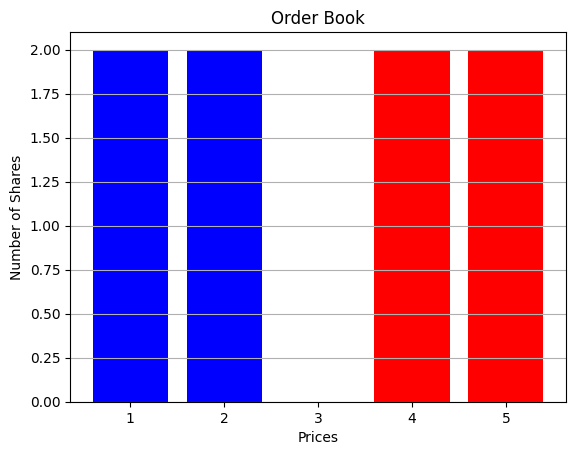


Bids
[DollarsAndShares(dollars=3, shares=0),
 DollarsAndShares(dollars=2, shares=2),
 DollarsAndShares(dollars=1, shares=2)]

Asks

[DollarsAndShares(dollars=4, shares=1), DollarsAndShares(dollars=5, shares=2)]



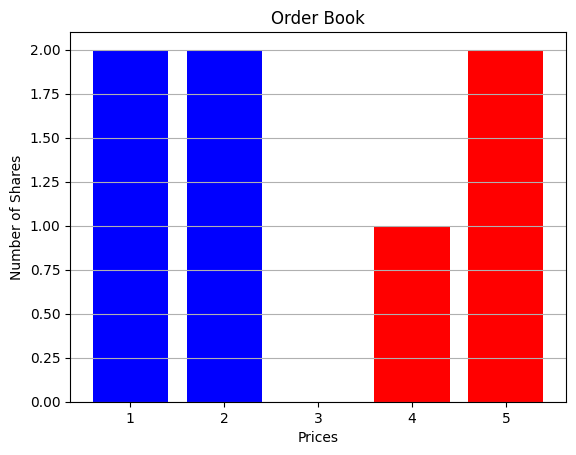


Bids
[DollarsAndShares(dollars=3, shares=0),
 DollarsAndShares(dollars=2, shares=2),
 DollarsAndShares(dollars=1, shares=4)]

Asks

[DollarsAndShares(dollars=4, shares=1), DollarsAndShares(dollars=5, shares=2)]



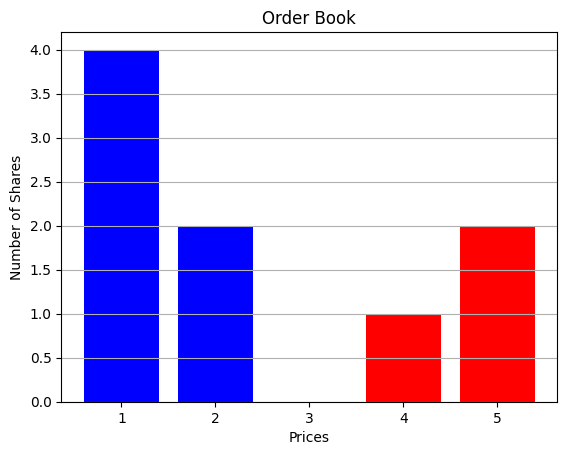

In [64]:
"""
We simulate a simple order book where a share can be sold for 5 different prices: $1, $2, $3, $4, $5. 
The order book can hold an order from 0-2 shares for the stock at each price. We model the process as
a markov model, where at each state of the order book, there is a 25% probability the order book receives
a market order to buy, 25% chance it receives a market order to sell, 25% chance it receives a limit order
to buy 2 shares at any price at random, and 25% chance it receives a limit order to sell 2 shares at any 
price at random. We choose the terminal states to be the states at which there are either no more bids or 
no more asks in the order book.

Although this is a very simplified version of the order book, it visually illustrates how an order book can
change over time. 
"""

# Producing a list of different combinations of quantities of shares at each of the prices
combinations = list(product([0, 1, 2], repeat=5))
combinations_lists = [list(combination) for combination in combinations]
prices = [i for i in range(1,6)]
states = []

# Adding each possible OrderBook state to the states list
for distribution in combinations_lists:
    for highest_bid in range(1, 6):
        bid_amounts = distribution[:highest_bid + 1]
        bid_prices = prices[:highest_bid + 1]
        ask_amounts = distribution[highest_bid + 1:]
        ask_prices = prices[highest_bid + 1:]
        
        bids = []
        asks = []
        for i in reversed(range(len(bid_amounts))):
            bids.append(DollarsAndShares(dollars=bid_prices[i], shares=bid_amounts[i]))
        for i in range(len(ask_amounts)):
            asks.append(DollarsAndShares(dollars=ask_prices[i], shares=ask_amounts[i]))
        states.append(OrderBook(descending_bids=bids, ascending_asks=asks))

# Creating the transition map
transition_map = {}
for state in states:
    if len(state.descending_bids) > 0 and len(state.ascending_asks) > 0:
        highest_bid = state.descending_bids[0].dollars
        lowest_ask = state.ascending_asks[0].dollars

        limit_order_price = random.randint(1, 5)
        d_s1, ob1 = state.sell_limit_order(limit_order_price, 2)
        d_s2, ob2 = state.buy_limit_order(limit_order_price, 2)
        d_s3, ob3 = state.buy_market_order(1)
        d_s4, ob4 = state.buy_market_order(1)

        transition_dict = {str(ob1): 0.25, str(ob2): 0.25, str(ob3): 0.25, str(ob4): 0.25}
        transition_map[str(state)] = Categorical(transition_dict)

    else:
        transition_map[str(state)] = Categorical({str(state): 1})

# Parsing through all the states which are represented in string form and converting them back into objects
def parse_section(section):
    pattern = r"DollarsAndShares\(dollars=(\d+), shares=(\d+)\)"
    return [DollarsAndShares(int(dollars), int(shares)) for dollars, shares in re.findall(pattern, section)]

finite_markov_process_instance = FiniteMarkovProcess(transition_map)

# Choosing a starting state
start_bids = [DollarsAndShares(dollars=3, shares=0), DollarsAndShares(dollars=2, shares=2), DollarsAndShares(dollars=1, shares=2)]
start_asks = [DollarsAndShares(dollars=4, shares=2), DollarsAndShares(dollars=5, shares=2)]
first_state = OrderBook(descending_bids=start_bids, ascending_asks=start_asks)
start_dist = Constant(NonTerminal((str(first_state))))

# Going through a trace example
num_traces = 1  
for i, trace in enumerate(finite_markov_process_instance.traces(start_dist)):
    trace_list = list(trace)
    if i >= num_traces - 1:
        break

bids_asks_pattern = r"descending_bids=\[(.*?)\], ascending_asks=\[(.*?)\]"
pattern = r"DollarsAndShares\(dollars=(\d+), shares=(\d+)\)"

# Visualising the order book at each step in the trace
for elem in trace_list:
    match = re.search(bids_asks_pattern, elem.state)
    bids_section, asks_section = match.groups()
    bids = parse_section(bids_section)
    asks = parse_section(asks_section)

    ob1 = OrderBook(descending_bids=bids, ascending_asks=asks)
    ob1.pretty_print_order_book()
    ob1.display_order_book()

## Question 4
Derive the expressions for the Optimal Value Function and Optimal Policy
for the *Linear-Percentage Temporary* (LPT) Price Impact Model
formulated by Bertsimas and Lo. The LPT model is described below for all
$t = 0, 1, \ldots T-1$:

$$P_{t+1} = P_t \cdot e^{Z_t}$$ 

$$X_{t+1} = \rho \cdot X_t + \eta_t$$

$$Q_t = P_t \cdot (1 - \beta \cdot N_t - \theta \cdot X_t)$$ 

where $Z_t$ are independent and identically distributed random variables with mean
$\mu_Z$ and variance $\sigma^2_Z$ for all $t = 0, 1, \ldots, T-1$,
$\eta_t$ are independent and identically distributed random variables
with mean 0 for all $t = 0, 1, \ldots, T-1$, $Z_t$ and $\eta_t$ are
independent of each other for all $t = 0, 1, \ldots, T-1$, and
$\rho, \beta, \theta$ are given constants. The model assumes no
risk-aversion (Utility function is the identity function) and so, the
objective is to maximize the Expected Total Sales Proceeds over the
finite-horizon up to time $T$ (discount factor is 1). In your
derivation, use the same methodology as we followed for the *Simple
Linear Price Impact Model with no Risk-Aversion*.

Implement this LPT model by customizing the class
`OptimalOrderExecution` in [rl/chapter9/optimal_order_execution.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/optimal_order_execution.py).

Compare the obtained Optimal Value Function and Optimal Policy against
the closed-form solution you derived above.

Value function $V^{\pi}t (P_t, R_t) = \mathbb{E}\pi \left[\sum_{i=1}^{T} N_i \left(P_i - \beta N_i - \theta X_t\right) \mid (P_t, R_t)\right]$.

Using the Bellman Equation:

$V^t(P_t, R_t) = \max{N_t} \left\{N_t (P_t - \beta N_t - \theta X_t) + \mathbb{E}\left[V_{t+1}(P_t, R_t)\right]\right\}.$

For $t=T - 1$,

$$V^*{T-1}(P{T-1}, R_{T-1}) = N_{T-1} (P_{T-1} - \beta N_{T-1} - \theta X_{T-1}).$$

For $t = T-2$,

$$V^*{T-2}(P{T-2}, R_{T-2}) = \max_{N_{T-2}} \left\{N_{T-2} (P_{T-2} - \beta N_{T-2} - \theta X_{T-2}) + \mathbb{E}\left[(R_{T-2} - N_{T-2}) (P_{T-1} - \beta (R_{T-2} - N_{T-2}) - \theta (\rho X_{T-2} + \eta_{T-2}))\right] \right\}.$$

$$
\begin{align*}
V^*{T-2}(P{T-2}, R_{T-2}) = \max_{N_{T-2}} \Big\{ & N_{T-2} (P_{T-2} - \beta N_{T-2} - \theta X_{T-2}) + \\
& \mathbb{E}\left[(R_{T-2} - N_{T-2}) (P_{T-1} - \beta (R_{T-2} - N_{T-2}) - \theta (\rho X_{T-2} + \eta_{T-2}))\right] \Big\}.
\end{align*}
$$

$$
\begin{align*}
= \max_{N_{T-2}} \Big\{ N_{T-2} P_{T-2} - \beta (N_{T-2})^2 + & \mathbb{E}\left[R_{T-2} P_{T-2} - \beta (R_{T-2})^2 + \beta R_{T-2} N_{T-2} - \theta \rho R_{T-2} X_{T-2} \right. \\
& \left. - \theta R_{T-2} \eta_{T-2} - N_{T-2} P_{T-1} + \beta R_{T-2} N_{T-2} - \beta (N_{T-2})^2 + \theta \rho N_{T-2} X_{T-2} + \theta \rho N_{T-2} \eta_{T-2}\right] \Big\}.
\end{align*}
$$

$$\begin{split}
= \max_{N_{T-2}} \Big\{ &N_{T-2} P_{T-2} - \beta (N_{T-2})^2 + R_{T-2} P_{T-2} \mathbb{E}\left[e^{Z_{T-2}}\right] - \beta (R_{T-2}) ^ 2 + \beta R_{T-2} N_{T-2} \\
&- \theta \rho R_{T-2} X_{T-2} - q N_{T-2} P_{T-2} + \beta R_{T-2} N_{T-2} - \beta (N_{T-2})^2 + \theta \rho N_{T-2} X_{T-2}\Big\}.
\end{split}$$

$$ = q R_{T-2} P_{T-2} - \beta (R_{T-2}) ^ 2 -\theta \rho X_{T-2} R_{T-2} + \max_{N_{T-2}}\left\{-2\beta (N_{T-2}) ^ 2 + N_{T-2} \left(2 \beta R_{T-2} + (1 - q) P_{T-2} + \theta \rho X_{T-2}\right)\right\},$$

where $q := \mathbb{E}[e^{Z_{T-2}}] = \exp(\mu_z + \frac{\sigma^2}{2})$ assuming that $\mu_z$ is distributed normally. In the not-trivial case where $\beta > 0$, we optimize for the vertex of the parabola with. Note that terms with $\eta_{T-2}$ cancel, because its mean is zero. So the optimal value of shares sold at time $T-2$

$$N^*{T-2} = \frac{R{T-2}}{2} + \frac{(1 - q) P_{T-2} + \theta \rho X_{T-2}}{4 \beta}.$$

Similarly, working recursively, we can find the optimal value of $N^*_t$.